In [1]:
# Imports
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [2]:
# --- Dataset Loading and Initial Assessment ---
df = pd.read_csv('C:/um/output/extracted_error_features.csv', dtype={
    'client_ip': str,
    'error_file': str,
    # Other columns needing specific dtypes
})
# Assuming 'df' is your DataFrame
df = df[df['month'].isin([10, 11, 12, 1,3])]
#df['client_ip'] = df['client_ip'].map(str)
#df['error_file'] = df['error_file'].map(str)

# Convert to strings only if original data types are compatible
df['client_ip'] = df['client_ip'].astype(str) 
df['error_file'] = df['error_file'].astype(str) 


C:\Users\Lai Wen Khai\AppData\Local\Temp\ipykernel_108\2531198696.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:/um/output/extracted_error_features.csv', dtype={


In [3]:
# --- Target Transformation ---
df['is_critical_error'] = df['error_level_encoded'] == 3

# Feature selection 
features_to_use = ['pid','client_ip', 'error_file', 'hour', 'day', 'month']  # Adjust this list!
X = df[features_to_use]  
y = df['is_critical_error'].astype(float)

# Select categorical columns
categorical_columns = ['client_ip', 'error_file']

In [4]:
from sklearn.preprocessing import OneHotEncoder

def encode_column_in_chunks(df, column_name, chunk_size=10000):
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)  # Dense output for simplicity
    chunks = []
    for i in range(0, len(df), chunk_size):
        df_chunk = df[i:i+chunk_size].copy()
        encoded_chunk = encoder.fit_transform(df_chunk[[column_name]])
        chunks.append(pd.DataFrame(encoded_chunk, index=df_chunk.index))
    return pd.concat(chunks)




In [5]:
# Apply encoding to a copy of the filtered data 
df_encoded = df.copy()  


for col in categorical_columns:
    encoded_data = encode_column_in_chunks(df_encoded.copy(), col)
    df_encoded = pd.concat([df_encoded.drop(col, axis=1), encoded_data], axis=1) 

#loop all column
for col in df_encoded.columns:
    df_encoded[col] = df_encoded[col].astype(str)

# Ensure remaining dtypes are appropriate 
print(df_encoded.info())

C:\Users\Lai Wen Khai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Lai Wen Khai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Lai Wen Khai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in vers

<class 'pandas.core.frame.DataFrame'>
Index: 563580 entries, 0 to 849409
Data columns (total 76 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   pid                  563580 non-null  object
 1   client_port          563580 non-null  object
 2   error_line           563580 non-null  object
 3   hour                 563580 non-null  object
 4   day                  563580 non-null  object
 5   month                563580 non-null  object
 6   year                 563580 non-null  object
 7   error_level_encoded  563580 non-null  object
 8   is_critical_error    563580 non-null  object
 9   0                    563580 non-null  object
 10  1                    563580 non-null  object
 11  0                    563580 non-null  object
 12  1                    563580 non-null  object
 13  2                    563580 non-null  object
 14  3                    563580 non-null  object
 15  4                    563580 non-null  o

In [6]:
# Assuming df_encoded is your DataFrame
prefix = 'review_'

# Get the first 9 columns
first_n_columns = df_encoded.iloc[:, :9]

# Get the columns starting from the 10th column onwards
columns_to_prefix = df_encoded.iloc[:, 9:]

# Add prefix to selected columns
columns_to_prefix = columns_to_prefix.add_prefix(prefix)

# Concatenate the first 9 columns with the modified columns
df_encoded = pd.concat([first_n_columns, columns_to_prefix], axis=1)

In [7]:
print(df_encoded.columns)

Index(['pid', 'client_port', 'error_line', 'hour', 'day', 'month', 'year',
       'error_level_encoded', 'is_critical_error', 'review_0', 'review_1',
       'review_0', 'review_1', 'review_2', 'review_3', 'review_4', 'review_5',
       'review_6', 'review_7', 'review_8', 'review_9', 'review_10',
       'review_11', 'review_12', 'review_13', 'review_14', 'review_15',
       'review_16', 'review_17', 'review_18', 'review_19', 'review_20',
       'review_21', 'review_22', 'review_23', 'review_24', 'review_25',
       'review_26', 'review_27', 'review_28', 'review_29', 'review_30',
       'review_31', 'review_32', 'review_33', 'review_34', 'review_35',
       'review_36', 'review_37', 'review_38', 'review_39', 'review_40',
       'review_41', 'review_42', 'review_43', 'review_44', 'review_45',
       'review_46', 'review_47', 'review_48', 'review_49', 'review_50',
       'review_51', 'review_52', 'review_53', 'review_54', 'review_55',
       'review_56', 'review_57', 'review_58', 'review_5

In [8]:
df_encoded['is_critical_error'] = df_encoded['is_critical_error'].map({'True': 1.0, 'False': 0.0})
df_encoded['is_critical_error'] = df_encoded['is_critical_error'].astype(float)

print(df_encoded.head)

<bound method NDFrame.head of           pid client_port error_line hour day month  year error_level_encoded  \
0       25869       50628          0    9  17     1  2022                   2   
1       25894       50636          0    9  17     1  2022                   2   
2       25929       52127          8   10  17     1  2022                   2   
3       25929       52127          8   10  17     1  2022                   2   
4       25929       52127         15   10  17     1  2022                   1   
...       ...         ...        ...  ...  ..   ...   ...                 ...   
849405  17509        6277         25   23  31     3  2023                   1   
849406  17509        6277        190   23  31     3  2023                   1   
849407  17518       11903         24   23  31     3  2023                   2   
849408  17543       41538         25   23  31     3  2023                   1   
849409  17543       41538        190   23  31     3  2023                   1  

In [9]:
# Split into features (X) and target (y)
X = df_encoded.drop('is_critical_error', axis=1)  
y = df_encoded['is_critical_error']

In [10]:
df_encoded = df_encoded.drop('is_critical_error', axis=1)  

In [11]:
df_encoded = df_encoded.drop('error_level_encoded', axis=1)
print(df_encoded.columns)

Index(['pid', 'client_port', 'error_line', 'hour', 'day', 'month', 'year',
       'review_0', 'review_1', 'review_0', 'review_1', 'review_2', 'review_3',
       'review_4', 'review_5', 'review_6', 'review_7', 'review_8', 'review_9',
       'review_10', 'review_11', 'review_12', 'review_13', 'review_14',
       'review_15', 'review_16', 'review_17', 'review_18', 'review_19',
       'review_20', 'review_21', 'review_22', 'review_23', 'review_24',
       'review_25', 'review_26', 'review_27', 'review_28', 'review_29',
       'review_30', 'review_31', 'review_32', 'review_33', 'review_34',
       'review_35', 'review_36', 'review_37', 'review_38', 'review_39',
       'review_40', 'review_41', 'review_42', 'review_43', 'review_44',
       'review_45', 'review_46', 'review_47', 'review_48', 'review_49',
       'review_50', 'review_51', 'review_52', 'review_53', 'review_54',
       'review_55', 'review_56', 'review_57', 'review_58', 'review_59',
       'review_60', 'review_61', 'review_62', '

In [12]:
unique_cols = ~df_encoded.columns.duplicated()
df_encoded = df_encoded.loc[:, unique_cols]
print(df_encoded.columns) 

Index(['pid', 'client_port', 'error_line', 'hour', 'day', 'month', 'year',
       'review_0', 'review_1', 'review_2', 'review_3', 'review_4', 'review_5',
       'review_6', 'review_7', 'review_8', 'review_9', 'review_10',
       'review_11', 'review_12', 'review_13', 'review_14', 'review_15',
       'review_16', 'review_17', 'review_18', 'review_19', 'review_20',
       'review_21', 'review_22', 'review_23', 'review_24', 'review_25',
       'review_26', 'review_27', 'review_28', 'review_29', 'review_30',
       'review_31', 'review_32', 'review_33', 'review_34', 'review_35',
       'review_36', 'review_37', 'review_38', 'review_39', 'review_40',
       'review_41', 'review_42', 'review_43', 'review_44', 'review_45',
       'review_46', 'review_47', 'review_48', 'review_49', 'review_50',
       'review_51', 'review_52', 'review_53', 'review_54', 'review_55',
       'review_56', 'review_57', 'review_58', 'review_59', 'review_60',
       'review_61', 'review_62', 'review_63', 'review_64']

In [13]:
from sklearn.impute import SimpleImputer


# Imputation after encoding
imputer = SimpleImputer(strategy='mean')  # Adjust strategy as needed
df_encoded = pd.DataFrame(imputer.fit_transform(df_encoded), columns=df_encoded.columns)


# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.2, random_state=42, stratify=y)


In [14]:
print(df_encoded.head())

       pid  client_port  error_line  hour   day  month    year  review_0  \
0  25869.0      50628.0         0.0   9.0  17.0    1.0  2022.0       1.0   
1  25894.0      50636.0         0.0   9.0  17.0    1.0  2022.0       1.0   
2  25929.0      52127.0         8.0  10.0  17.0    1.0  2022.0       1.0   
3  25929.0      52127.0         8.0  10.0  17.0    1.0  2022.0       1.0   
4  25929.0      52127.0        15.0  10.0  17.0    1.0  2022.0       1.0   

   review_1  review_2  ...  review_55  review_56  review_57  review_58  \
0  0.083125       0.0  ...        0.0        0.0        0.0        0.0   
1  0.083125       0.0  ...        0.0        0.0        0.0        0.0   
2  0.083125       0.0  ...        0.0        0.0        0.0        0.0   
3  0.083125       0.0  ...        0.0        0.0        0.0        0.0   
4  0.083125       0.0  ...        0.0        0.0        0.0        0.0   

   review_59  review_60  review_61  review_62  review_63  review_64  
0        1.0     0.0224     

In [15]:
from sklearn.ensemble import RandomForestClassifier 

# Gradient Boosting Machine
gbm_model = lgb.LGBMClassifier(random_state=42) 


In [16]:
from sklearn.model_selection import GridSearchCV
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [4, 6, 8],     # Possibly reduce max_depth
    'num_leaves': [32, 64, 128], # Increase num_leaves
    'learning_rate': [0.01, 0.05, 0.1] 
}


grid_search = GridSearchCV(gbm_model, param_grid, cv=5) 
grid_search.fit(X_train, y_train) 



[LightGBM] [Info] Number of positive: 747, number of negative: 359944
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 911
[LightGBM] [Info] Number of data points in the train set: 360691, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002071 -> initscore=-6.177639
[LightGBM] [Info] Start training from score -6.177639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [32, 64, 128]})

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Evaluation
y_pred = best_model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
# ... Other metrics ... 
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

Accuracy: 0.9980393200610383
Confusion Matrix:
 [[112332    151]
 [    70    163]]


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score
print("LightGBM Accuracy:", accuracy_score(y_test, y_pred))
print("LightGBM Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("precision:", precision_score(y_test, y_pred))
print("recall:", recall_score(y_test, y_pred))
print("f1:", f1_score(y_test, y_pred))

LightGBM Accuracy: 0.9980393200610383
LightGBM Confusion Matrix:
 [[112332    151]
 [    70    163]]
precision: 0.5191082802547771
recall: 0.6995708154506438
f1: 0.5959780621572213


<Axes: xlabel='Predicted', ylabel='Actual'>

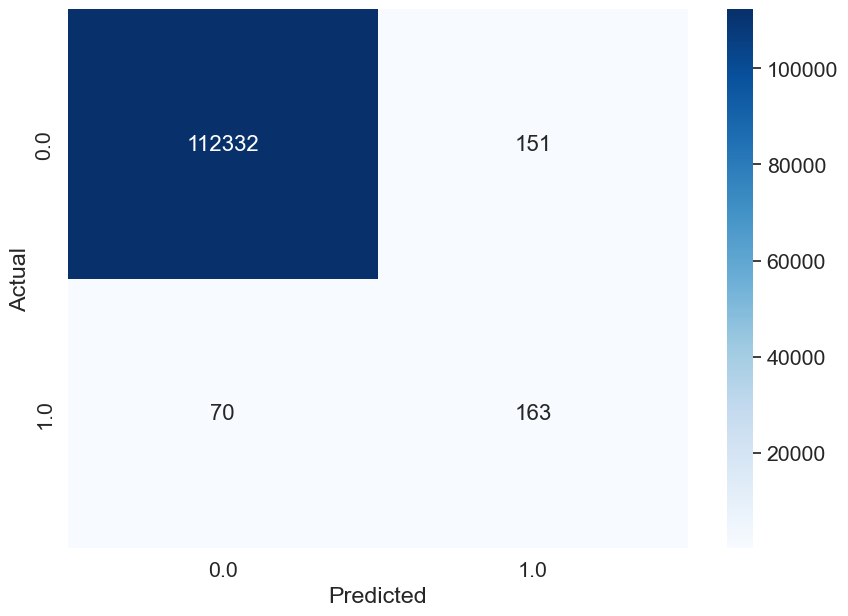

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')